K-Nearest Neighbors Hyperparameter Tuning

In [32]:
#Import some basic packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
sns.set_style("whitegrid")


In [33]:
#Let's import the data and instanciate a train/test split with the seed everyrone is using.

cal_fire_data = pd.read_csv('../data/cal_fire_data_cleaned.csv')

from sklearn.model_selection import train_test_split
cal_fire_data_train,cal_fire_data_test = train_test_split(cal_fire_data, test_size=.2, random_state=216, shuffle=True, stratify=cal_fire_data['Destroyed'])


In [34]:
#Let's import all the functions from sklearn that we're using.

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score


In [35]:
#We're starting with all categorical variables for KNN. Let's use Bootstrapping to do some hyperparameter tuning.

#We first need to prep the categorical variables with a preprocessor.

preprocessor = ColumnTransformer(
    transformers=[
        ("Structure Type", OneHotEncoder(), ['* Structure Type']),
        ("Roof Construction", OneHotEncoder(), ['* Roof Construction']),
        ("Eaves", OneHotEncoder(), ['* Eaves']),
        ("Vent Screen", OneHotEncoder(), ['* Vent Screen']),
        ("Exterior Siding", OneHotEncoder(), ['* Exterior Siding']),
        ("Window Pane", OneHotEncoder(), ['* Window Pane']),
        ("Elevated", OneHotEncoder(), ['* Deck/Porch Elevated']),
        ("Patio Cover/Carport Attached", OneHotEncoder(), ['* Patio Cover/Carport Attached to Structure']),
        ("Fence Attached to Structure", OneHotEncoder(), ['* Fence Attached to Structure'])
        ])

#We are ready to start.

n_splits = 50
kfold = StratifiedKFold(n_splits, shuffle=True, random_state=216)
ks = [i for i in range(1,35)] + [(35 + i*3) for i in range(1,31)]
k_all_accs = np.zeros((n_splits, len(ks)))
k_all_recs = np.zeros((n_splits, len(ks)))
k_all_precs = np.zeros((n_splits, len(ks))) 

i = 0

for train_index, test_index in kfold.split(cal_fire_data_train, cal_fire_data_train['Destroyed']):
    cal_fire_data_tt = cal_fire_data_train.iloc[train_index]
    cal_fire_data_ho = cal_fire_data_train.iloc[test_index]
    j = 0

    for k in ks:
        model = Pipeline([('Preprocess', preprocessor),
                        ('knn',KNeighborsClassifier(k))])

        model.fit(cal_fire_data_tt[['* Structure Type', '* Roof Construction', '* Eaves', '* Vent Screen',
       '* Exterior Siding', '* Window Pane', '* Deck/Porch On Grade',
       '* Deck/Porch Elevated', '* Patio Cover/Carport Attached to Structure',
       '* Fence Attached to Structure']],cal_fire_data_tt['Destroyed'])

        pred = model.predict(cal_fire_data_ho[['* Structure Type', '* Roof Construction', '* Eaves', '* Vent Screen',
       '* Exterior Siding', '* Window Pane', '* Deck/Porch On Grade',
       '* Deck/Porch Elevated', '* Patio Cover/Carport Attached to Structure',
       '* Fence Attached to Structure']])

        k_all_accs[i,j] = accuracy_score(cal_fire_data_ho.Destroyed.values, pred)
        k_all_precs[i,j] = precision_score(cal_fire_data_ho.Destroyed.values, pred)
        k_all_recs[i,j] = recall_score(cal_fire_data_ho.Destroyed.values, pred)
        j +=1
    i += 1


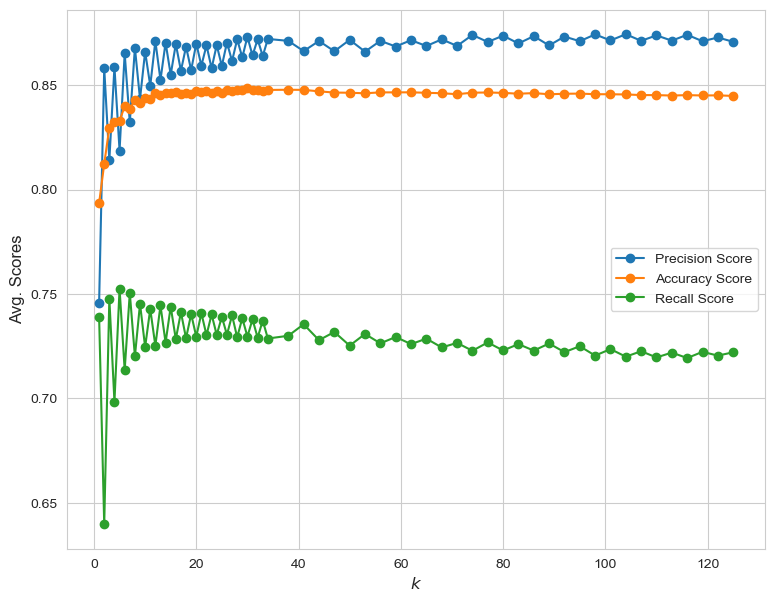

The best accuracy score, 0.8484707388910238 is attained when k= 29 neighbors.
The best precision score, 0.874389150458933 is attained when k= 56 neighbors.
The best recall score, 0.752565744400527 is attained when k= 4 neighbors.


In [36]:
#Let's visualize this data.

plt.figure(figsize=(9,7))

plt.plot(ks, 
         np.mean(k_all_precs, axis=0),  
         '-o',
         label = 'Precision Score')

plt.plot(ks, 
         np.mean(k_all_accs, axis=0), 
         '-o',
         label = 'Accuracy Score')

plt.plot(ks, 
         np.mean(k_all_recs, axis=0),
         '-o',
          label = 'Recall Score')


plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.xlabel("$k$", fontsize=12)
plt.ylabel("Avg. Scores", fontsize=12)
plt.legend(loc = 'center right')

plt.show()

print('The best accuracy score,', max(np.mean(k_all_accs, axis = 0)), 'is attained when k=', np.argmax(np.mean(k_all_accs, axis = 0)), 'neighbors.')
print('The best precision score,', max(np.mean(k_all_precs, axis = 0)), 'is attained when k=', np.argmax(np.mean(k_all_precs, axis = 0)), 'neighbors.')
print('The best recall score,', max(np.mean(k_all_recs, axis = 0)), 'is attained when k=', np.argmax(np.mean(k_all_recs, axis = 0)), 'neighbors.')


In [37]:
print('With 28 neighbors, the precision score is', np.mean(k_all_precs, axis = 0)[28], 'and the recall score is', np.mean(k_all_recs, axis = 0)[28])

#It seems like approximately 28 neighbors might be a good hyperparameter, as it maximizes accuracy and obtains good recall and precision scores.


With 28 neighbors, the precision score is 0.8632689325677418 and the recall score is 0.738408695652174


In [38]:
#Let us see if it's useful to drop some variables. Let's focus on accuracy. We can still play a bit with the hyperparameter to see if we get some improvement.

n_splits = 15
ks = [25,26,27,28,29,30,31]

for k in ks:
    Accs_avg = np.zeros((10))

    kfold = StratifiedKFold(n_splits,
                            shuffle=True,
                            random_state=216)

    i = 0

    for c in cal_fire_data_train.columns[:-5]:
        cal_fire_data_minus = cal_fire_data_train.copy()
        cal_fire_data_minus[c] = 0
        accs = []
        preprocessor = ColumnTransformer(
        transformers=[
            ("Structure Type", OneHotEncoder(), ['* Structure Type']),
            ("Roof Construction", OneHotEncoder(), ['* Roof Construction']),
            ("Eaves", OneHotEncoder(), ['* Eaves']),
            ("Vent Screen", OneHotEncoder(), ['* Vent Screen']),
            ("Exterior Siding", OneHotEncoder(), ['* Exterior Siding']),
            ("Window Pane", OneHotEncoder(), ['* Window Pane']),
            ("Elevated", OneHotEncoder(), ['* Deck/Porch Elevated']),
            ("Patio Cover/Carport Attached", OneHotEncoder(), ['* Patio Cover/Carport Attached to Structure']),
            ("Fence Attached to Structure", OneHotEncoder(), ['* Fence Attached to Structure'])
            ])
        model = Pipeline([('Preprocess', preprocessor), ('knn',KNeighborsClassifier(k))])



        for train_index, test_index in kfold.split(cal_fire_data_minus, cal_fire_data_minus['Destroyed']):
            cal_fire_data_tt = cal_fire_data_minus.iloc[train_index]
            cal_fire_data_ho = cal_fire_data_minus.iloc[test_index]
            model.fit(cal_fire_data_tt[cal_fire_data_tt.columns[:-5]], cal_fire_data_tt['Destroyed'])
            pred = model.predict(cal_fire_data_ho[cal_fire_data_ho.columns[:-5]])
            accs = accs + [accuracy_score(cal_fire_data_ho.Destroyed.values, pred)]
        
        Accs_avg[i] = np.mean(accs)
        i += 1
    print('For', k, 'Neighbors:')
    print('The average accuracy with all 10 variables was', np.mean(k_all_accs, axis = 0)[k])
    print('The average accuracy when removing the variables are', Accs_avg)
    print('\n')


For 25 Neighbors:
The average accuracy with all 10 variables was 0.8476522388696809
The average accuracy when removing the variables are [0.84502381 0.84446872 0.84490696 0.84499439 0.7155216  0.84461475
 0.84581271 0.84587109 0.84855862 0.84432251]


For 26 Neighbors:
The average accuracy with all 10 variables was 0.8473019165919672
The average accuracy when removing the variables are [0.84630922 0.84446866 0.84557881 0.84528655 0.71514174 0.84552036
 0.84636765 0.84595878 0.84879227 0.84496523]


For 27 Neighbors:
The average accuracy with all 10 variables was 0.8478273786656427
The average accuracy when removing the variables are [0.84534514 0.84435185 0.84546191 0.84435172 0.71540463 0.84516976
 0.84607555 0.845725   0.84794513 0.84297863]


For 28 Neighbors:
The average accuracy with all 10 variables was 0.8475650318009141
The average accuracy when removing the variables are [0.84543277 0.84502369 0.84584175 0.84537426 0.71607654 0.84546195
 0.8463385  0.84639693 0.84847097 0.8448

In [39]:
#Let's see what happens when we add the variables which are not categorical. Let's try to add them one by one. 

n_splits = 15
ks = [25,26,27,28,29,30,31]

for k in ks:
    Accs_avg = np.zeros((4))

    kfold = StratifiedKFold(n_splits,
                            shuffle=True,
                            random_state=216)

    i = 0

    for c in cal_fire_data_train.columns[-5:-1]:
        accs = []
        preprocessor = ColumnTransformer(
        transformers=[
            ("Structure Type", OneHotEncoder(), ['* Structure Type']),
            ("Roof Construction", OneHotEncoder(), ['* Roof Construction']),
            ("Eaves", OneHotEncoder(), ['* Eaves']),
            ("Vent Screen", OneHotEncoder(), ['* Vent Screen']),
            ("Exterior Siding", OneHotEncoder(), ['* Exterior Siding']),
            ("Window Pane", OneHotEncoder(), ['* Window Pane']),
            ("Elevated", OneHotEncoder(), ['* Deck/Porch Elevated']),
            ("Patio Cover/Carport Attached", OneHotEncoder(), ['* Patio Cover/Carport Attached to Structure']),
            ("Fence Attached to Structure", OneHotEncoder(), ['* Fence Attached to Structure']),
            ("c", StandardScaler(), [c])
            ])
        model = Pipeline([('Preprocess', preprocessor), ('knn',KNeighborsClassifier(k))])



        for train_index, test_index in kfold.split(cal_fire_data_train, cal_fire_data_train['Destroyed']):
            cal_fire_data_tt = cal_fire_data_train.iloc[train_index]
            cal_fire_data_ho = cal_fire_data_train.iloc[test_index]
            model.fit(cal_fire_data_tt[list(cal_fire_data_tt.columns[:-5]) + [c]], cal_fire_data_tt['Destroyed'])
            pred = model.predict(cal_fire_data_ho[list(cal_fire_data_ho.columns[:-5])+[c]])
            accs = accs + [accuracy_score(cal_fire_data_ho.Destroyed.values, pred)]
        
        Accs_avg[i] = np.mean(accs)
        i += 1
    print('For', k, 'Neighbors:')
    print('The average accuracy score with all 10 variables was', np.mean(k_all_accs, axis = 0)[k])
    print('The average accuracy scores when adding the variables are', Accs_avg)
    print('\n')


For 25 Neighbors:
The average accuracy score with all 10 variables was 0.8476522388696809
The average accuracy scores when adding the variables are [0.84812035 0.85995175 0.86202582 0.84706871]


For 26 Neighbors:
The average accuracy score with all 10 variables was 0.8473019165919672
The average accuracy scores when adding the variables are [0.84791583 0.86044833 0.86182133 0.84654286]


For 27 Neighbors:
The average accuracy score with all 10 variables was 0.8478273786656427
The average accuracy scores when adding the variables are [0.84782829 0.85922139 0.86091582 0.84616313]


For 28 Neighbors:
The average accuracy score with all 10 variables was 0.8475650318009141
The average accuracy scores when adding the variables are [0.8482664  0.85925055 0.86097421 0.8470103 ]


For 29 Neighbors:
The average accuracy score with all 10 variables was 0.8484707388910238
The average accuracy scores when adding the variables are [0.84800355 0.85907525 0.86041914 0.84601711]


For 30 Neighbors:
Th

In [40]:
#It seems like we had some improvement, especially with 'Longitude'. Let's add it and repeat the process.
#Let's expand the number of neighbors we check since the best imporvement happened at 25 neighbors.
#Since we have few variables, a hyperparameter and running this takes so long, we go with a manual approach instead of an automated.

n_splits = 30
ks = [20,21,22,23,24,25,26,27,28,29,30,31]

all_accs = np.zeros((n_splits,len(ks),4))

j = 0

for k in ks:
    Accs_avg = np.zeros(())

    kfold = StratifiedKFold(n_splits,
                            shuffle=True,
                            random_state=216)

    preprocessor = ColumnTransformer(
        transformers=[
            ("Structure Type", OneHotEncoder(), ['* Structure Type']),
            ("Roof Construction", OneHotEncoder(), ['* Roof Construction']),
            ("Eaves", OneHotEncoder(), ['* Eaves']),
            ("Vent Screen", OneHotEncoder(), ['* Vent Screen']),
            ("Exterior Siding", OneHotEncoder(), ['* Exterior Siding']),
            ("Window Pane", OneHotEncoder(), ['* Window Pane']),
            ("Elevated", OneHotEncoder(), ['* Deck/Porch Elevated']),
            ("Patio Cover/Carport Attached", OneHotEncoder(), ['* Patio Cover/Carport Attached to Structure']),
            ("Fence Attached to Structure", OneHotEncoder(), ['* Fence Attached to Structure']),
            ("Longitude", StandardScaler(), ['Longitude'])
            ])
    model = Pipeline([('Preprocess', preprocessor), ('knn',KNeighborsClassifier(k))])

    i = 0

    for train_index, test_index in kfold.split(cal_fire_data_train, cal_fire_data_train['Destroyed']):
        cal_fire_data_tt = cal_fire_data_train.iloc[train_index]
        cal_fire_data_ho = cal_fire_data_train.iloc[test_index]

        model.fit(cal_fire_data_tt[list(cal_fire_data_tt.columns[:-5]) + ['Longitude']], cal_fire_data_tt['Destroyed'])
        pred = model.predict(cal_fire_data_ho[list(cal_fire_data_ho.columns[:-5])+['Longitude']])

        all_accs[i][j][0] = accuracy_score(cal_fire_data_ho.Destroyed.values, pred)
        i += 1
    l = 1

    for c in ['Assessed Improved Value (parcel)','Latitude','Age']:
        preprocessor = ColumnTransformer(
        transformers=[
            ("Structure Type", OneHotEncoder(), ['* Structure Type']),
            ("Roof Construction", OneHotEncoder(), ['* Roof Construction']),
            ("Eaves", OneHotEncoder(), ['* Eaves']),
            ("Vent Screen", OneHotEncoder(), ['* Vent Screen']),
            ("Exterior Siding", OneHotEncoder(), ['* Exterior Siding']),
            ("Window Pane", OneHotEncoder(), ['* Window Pane']),
            ("Elevated", OneHotEncoder(), ['* Deck/Porch Elevated']),
            ("Patio Cover/Carport Attached", OneHotEncoder(), ['* Patio Cover/Carport Attached to Structure']),
            ("Fence Attached to Structure", OneHotEncoder(), ['* Fence Attached to Structure']),
            ("Longitude", StandardScaler(), ['Longitude']),
            ("c", StandardScaler(), [c])
            ])
        model = Pipeline([('Preprocess', preprocessor), ('knn',KNeighborsClassifier(k))])

        i = 0

        for train_index, test_index in kfold.split(cal_fire_data_train, cal_fire_data_train['Destroyed']):
            cal_fire_data_tt = cal_fire_data_train.iloc[train_index]
            cal_fire_data_ho = cal_fire_data_train.iloc[test_index]
            model.fit(cal_fire_data_tt[list(cal_fire_data_tt.columns[:-5]) + [c] + ['Longitude']], cal_fire_data_tt['Destroyed'])
            pred = model.predict(cal_fire_data_ho[list(cal_fire_data_ho.columns[:-5])+[c] + ['Longitude']])
        
            all_accs[i][j][l] = accuracy_score(cal_fire_data_ho.Destroyed.values, pred)
            i += 1
        l += 1
    print('For', k, 'Neighbors:')
    print('The average accuracy score with all 10 variables and Longitude was', np.mean(all_accs, axis = 0)[j][0])
    print('The average accuracy scores when adding the variables are', np.mean(all_accs, axis = 0)[j][1:])
    print('\n')
    print('The maximum average score is', np.max(np.mean(all_accs, axis=0)))
    j +=1

print('The highest accuracy score of', np.max(np.mean(all_accs, axis=0))) #, 'was attained with', np.argmax(np.mean(all_accs, axis=0))[0] + 20, 'neighbors.') 


For 20 Neighbors:
The average accuracy score with all 10 variables and Longitude was 0.865443842595648
The average accuracy scores when adding the variables are [0.86155854 0.86591122 0.85416731]


The maximum average score is 0.8659112176668288
For 21 Neighbors:
The average accuracy score with all 10 variables and Longitude was 0.8641585227775636
The average accuracy scores when adding the variables are [0.86106195 0.86491796 0.85270671]


The maximum average score is 0.8659112176668288
For 22 Neighbors:
The average accuracy score with all 10 variables and Longitude was 0.8644505362662078
The average accuracy scores when adding the variables are [0.86150001 0.86576515 0.85355387]


The maximum average score is 0.8659112176668288
For 23 Neighbors:
The average accuracy score with all 10 variables and Longitude was 0.863895569939213
The average accuracy scores when adding the variables are [0.85965952 0.86392471 0.85261912]


The maximum average score is 0.8659112176668288
For 24 Neighbo

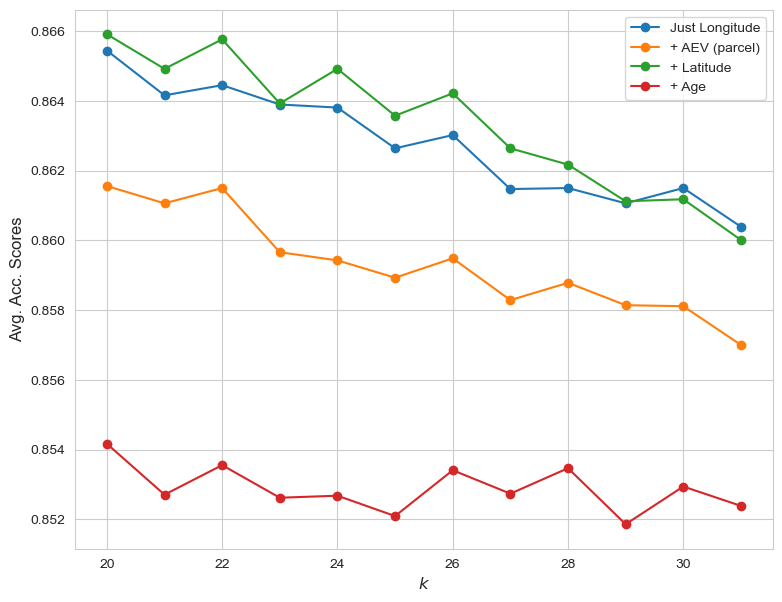

In [41]:
#Let's visualize this data.

plt.figure(figsize=(9,7))

plt.plot(ks, 
         np.mean(all_accs, axis=0)[:,0],  
         '-o',
         label = 'Just Longitude')

plt.plot(ks, 
         np.mean(all_accs, axis=0)[:,1], 
         '-o',
         label = '+ AEV (parcel)')

plt.plot(ks, 
         np.mean(all_accs, axis=0)[:,2],
         '-o',
          label = '+ Latitude')

plt.plot(ks, 
         np.mean(all_accs, axis=0)[:,3],
         '-o',
          label = '+ Age')


plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.xlabel("$k$", fontsize=12)
plt.ylabel("Avg. Acc. Scores", fontsize=12)
plt.legend()

plt.show()


In [42]:
# Based on the previous information, we should add Latitude and adjust the number of neighbors. 
# For sanity, let's check if a new variable should be added afterwards.

n_splits = 30
ks = [i for i in range(10,30)]

all_accs = np.zeros((n_splits,len(ks),3))

j = 0

for k in ks:
    kfold = StratifiedKFold(n_splits,
                            shuffle=True,
                            random_state=216)

    preprocessor = ColumnTransformer(
        transformers=[
            ("Structure Type", OneHotEncoder(), ['* Structure Type']),
            ("Roof Construction", OneHotEncoder(), ['* Roof Construction']),
            ("Eaves", OneHotEncoder(), ['* Eaves']),
            ("Vent Screen", OneHotEncoder(), ['* Vent Screen']),
            ("Exterior Siding", OneHotEncoder(), ['* Exterior Siding']),
            ("Window Pane", OneHotEncoder(), ['* Window Pane']),
            ("Elevated", OneHotEncoder(), ['* Deck/Porch Elevated']),
            ("Patio Cover/Carport Attached", OneHotEncoder(), ['* Patio Cover/Carport Attached to Structure']),
            ("Fence Attached to Structure", OneHotEncoder(), ['* Fence Attached to Structure']),
            ("Longitude", StandardScaler(), ['Longitude']),
            ("Latitude", StandardScaler(), ['Latitude'])
            ])
    model = Pipeline([('Preprocess', preprocessor), ('knn',KNeighborsClassifier(k))])

    i = 0

    for train_index, test_index in kfold.split(cal_fire_data_train, cal_fire_data_train['Destroyed']):
        cal_fire_data_tt = cal_fire_data_train.iloc[train_index]
        cal_fire_data_ho = cal_fire_data_train.iloc[test_index]

        model.fit(cal_fire_data_tt[list(cal_fire_data_tt.columns[:-5]) + ['Longitude'] + ['Latitude']], cal_fire_data_tt['Destroyed'])
        pred = model.predict(cal_fire_data_ho[list(cal_fire_data_ho.columns[:-5])+['Longitude']+['Latitude']])

        all_accs[i][j][0] = accuracy_score(cal_fire_data_ho.Destroyed.values, pred)
        i += 1
    l = 1

    for c in ['Assessed Improved Value (parcel)','Age']:
        preprocessor = ColumnTransformer(
        transformers=[
            ("Structure Type", OneHotEncoder(), ['* Structure Type']),
            ("Roof Construction", OneHotEncoder(), ['* Roof Construction']),
            ("Eaves", OneHotEncoder(), ['* Eaves']),
            ("Vent Screen", OneHotEncoder(), ['* Vent Screen']),
            ("Exterior Siding", OneHotEncoder(), ['* Exterior Siding']),
            ("Window Pane", OneHotEncoder(), ['* Window Pane']),
            ("Elevated", OneHotEncoder(), ['* Deck/Porch Elevated']),
            ("Patio Cover/Carport Attached", OneHotEncoder(), ['* Patio Cover/Carport Attached to Structure']),
            ("Fence Attached to Structure", OneHotEncoder(), ['* Fence Attached to Structure']),
            ("Longitude", StandardScaler(), ['Longitude']),
            ("Latitude", StandardScaler(), ['Latitude']),
            ("c", StandardScaler(), [c])
            ])
        model = Pipeline([('Preprocess', preprocessor), ('knn',KNeighborsClassifier(k))])

        i = 0

        for train_index, test_index in kfold.split(cal_fire_data_train, cal_fire_data_train['Destroyed']):
            cal_fire_data_tt = cal_fire_data_train.iloc[train_index]
            cal_fire_data_ho = cal_fire_data_train.iloc[test_index]
            model.fit(cal_fire_data_tt[list(cal_fire_data_tt.columns[:-5]) + [c] + ['Longitude']+['Latitude']], cal_fire_data_tt['Destroyed'])
            pred = model.predict(cal_fire_data_ho[list(cal_fire_data_ho.columns[:-5])+[c] + ['Longitude']+['Latitude']])
        
            all_accs[i][j][l] = accuracy_score(cal_fire_data_ho.Destroyed.values, pred)
            i += 1
        l += 1
    print('For', k, 'Neighbors:')
    print('The average accuracy score with all 10 variables with Latitude Longitude was', np.mean(all_accs, axis = 0)[j][0])
    print('The average accuracy scores when adding the variables AIV and Age are', np.mean(all_accs, axis = 0)[j][1:])
    print('\n')
    print('The maximum average score is', np.max(np.mean(all_accs, axis=0)))
    j +=1

print('The highest accuracy score of', np.max(np.mean(all_accs, axis=0))) #, 'was attained with', np.argmax(np.mean(all_accs, axis=0))[0] + 20, 'neighbors.') 


For 10 Neighbors:
The average accuracy score with all 10 variables with Latitude Longitude was 0.8664080115301199
The average accuracy scores when adding the variables AIV and Age are [0.8636912  0.85641662]


The maximum average score is 0.8664080115301199
For 11 Neighbors:
The average accuracy score with all 10 variables with Latitude Longitude was 0.8659989879935514
The average accuracy scores when adding the variables AIV and Age are [0.86293171 0.85384585]


The maximum average score is 0.8664080115301199
For 12 Neighbors:
The average accuracy score with all 10 variables with Latitude Longitude was 0.8681315946059748
The average accuracy scores when adding the variables AIV and Age are [0.86439239 0.85644581]


The maximum average score is 0.8681315946059748
For 13 Neighbors:
The average accuracy score with all 10 variables with Latitude Longitude was 0.8661450331102108
The average accuracy scores when adding the variables AIV and Age are [0.86369115 0.85437163]


The maximum aver

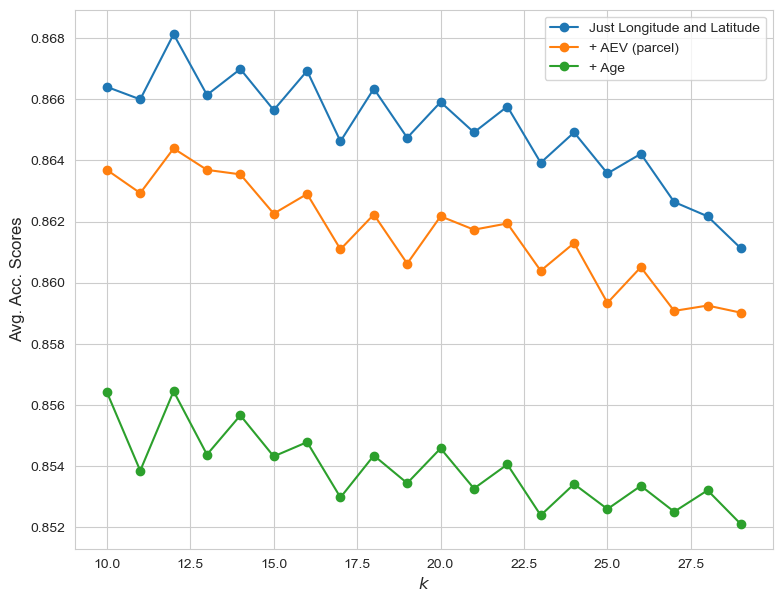

In [43]:
plt.figure(figsize=(9,7))

plt.plot(ks, 
         np.mean(all_accs, axis=0)[:,0],  
         '-o',
         label = 'Just Longitude and Latitude')

plt.plot(ks, 
         np.mean(all_accs, axis=0)[:,1], 
         '-o',
         label = '+ AEV (parcel)')

plt.plot(ks, 
         np.mean(all_accs, axis=0)[:,2],
         '-o',
          label = '+ Age')


plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.xlabel("$k$", fontsize=12)
plt.ylabel("Avg. Acc. Scores", fontsize=12)
plt.legend()

plt.show()


In [44]:
#It seems like we have the model as good as it's going to get: almost 87% accuracy.
#This is with 12 neighbors and 10 variables.
#Let's, just for sanity, see what happens if we removed a categorical variable now.


In [46]:
n_splits = 40
ks = [i for i in range(4,24)]

all_accs = np.zeros((n_splits,len(ks),11))

j = 0

for k in ks:
    kfold = StratifiedKFold(n_splits,
                            shuffle=True,
                            random_state=216)

    preprocessor = ColumnTransformer(
        transformers=[
            ("Structure Type", OneHotEncoder(), ['* Structure Type']),
            ("Roof Construction", OneHotEncoder(), ['* Roof Construction']),
            ("Eaves", OneHotEncoder(), ['* Eaves']),
            ("Vent Screen", OneHotEncoder(), ['* Vent Screen']),
            ("Exterior Siding", OneHotEncoder(), ['* Exterior Siding']),
            ("Window Pane", OneHotEncoder(), ['* Window Pane']),
            ("Elevated", OneHotEncoder(), ['* Deck/Porch Elevated']),
            ("Patio Cover/Carport Attached", OneHotEncoder(), ['* Patio Cover/Carport Attached to Structure']),
            ("Fence Attached to Structure", OneHotEncoder(), ['* Fence Attached to Structure']),
            ("Longitude", StandardScaler(), ['Longitude']),
            ("Latitude", StandardScaler(), ['Latitude'])
            ])
    model = Pipeline([('Preprocess', preprocessor), ('knn',KNeighborsClassifier(k))])

    i = 0

    for train_index, test_index in kfold.split(cal_fire_data_train, cal_fire_data_train['Destroyed']):
        cal_fire_data_tt = cal_fire_data_train.iloc[train_index]
        cal_fire_data_ho = cal_fire_data_train.iloc[test_index]

        model.fit(cal_fire_data_tt[list(cal_fire_data_tt.columns[:-5]) + ['Longitude'] + ['Latitude']], cal_fire_data_tt['Destroyed'])
        pred = model.predict(cal_fire_data_ho[list(cal_fire_data_ho.columns[:-5])+['Longitude']+['Latitude']])

        all_accs[i][j][0] = accuracy_score(cal_fire_data_ho.Destroyed.values, pred)
        i += 1
    l = 1

    for c in cal_fire_data_test.columns[:-5]:
        cal_fire_data_minus = cal_fire_data_test.copy()
        cal_fire_data_minus[c] = 0
        preprocessor = ColumnTransformer(
        transformers=[
            ("Structure Type", OneHotEncoder(handle_unknown='ignore'), ['* Structure Type']),
            ("Roof Construction", OneHotEncoder(handle_unknown='ignore'), ['* Roof Construction']),
            ("Eaves", OneHotEncoder(handle_unknown='ignore'), ['* Eaves']),
            ("Vent Screen", OneHotEncoder(handle_unknown='ignore'), ['* Vent Screen']),
            ("Exterior Siding", OneHotEncoder(handle_unknown='ignore'), ['* Exterior Siding']),
            ("Window Pane", OneHotEncoder(handle_unknown='ignore'), ['* Window Pane']),
            ("Elevated", OneHotEncoder(handle_unknown='ignore'), ['* Deck/Porch Elevated']),
            ("Patio Cover/Carport Attached", OneHotEncoder(handle_unknown='ignore'), ['* Patio Cover/Carport Attached to Structure']),
            ("Fence Attached to Structure", OneHotEncoder(handle_unknown='ignore'), ['* Fence Attached to Structure']),
            ("Longitude", StandardScaler(), ['Longitude']),
            ("Latitude", StandardScaler(), ['Latitude'])
            ])
        model = Pipeline([('Preprocess', preprocessor), ('knn',KNeighborsClassifier(k))])

        i = 0

        for train_index, test_index in kfold.split(cal_fire_data_minus, cal_fire_data_minus['Destroyed']):
            cal_fire_data_tt = cal_fire_data_minus.iloc[train_index]
            cal_fire_data_ho = cal_fire_data_minus.iloc[test_index]
            model.fit(cal_fire_data_tt[list(cal_fire_data_tt.columns[:-5]) + ['Longitude']+['Latitude']], cal_fire_data_tt['Destroyed'])
            pred = model.predict(cal_fire_data_ho[list(cal_fire_data_ho.columns[:-5]) + ['Longitude']+['Latitude']])
        
            all_accs[i][j][l] = accuracy_score(cal_fire_data_ho.Destroyed.values, pred)
            i += 1
        l += 1
    print('For', k, 'Neighbors:')
    print('The average accuracy score with all 10 categorical variables with Latitude Longitude was', np.mean(all_accs, axis = 0)[j][0])
    print('The average accuracy scores when removing a categorical variable are', np.mean(all_accs, axis = 0)[j][1:])
    print('\n')
    print('The maximum average score is', np.max(np.mean(all_accs, axis=0)))
    j +=1

print('The highest accuracy score of', np.max(np.mean(all_accs, axis=0))) #, 'was attained with', np.argmax(np.mean(all_accs, axis=0))[0] + 20, 'neighbors.') 


For 4 Neighbors:
The average accuracy score with all 10 categorical variables with Latitude Longitude was 0.8701758826583592
The average accuracy scores when removing a categorical variable are [0.84330657 0.84494373 0.83991652 0.84447753 0.81269196 0.84587776
 0.84225407 0.8463445  0.84844621 0.84774527]


The maximum average score is 0.8701758826583592
For 5 Neighbors:
The average accuracy score with all 10 categorical variables with Latitude Longitude was 0.8680433267748808
The average accuracy scores when removing a categorical variable are [0.83804846 0.83582884 0.83757953 0.83547947 0.80848581 0.83816583
 0.83816145 0.84388739 0.8404957  0.84552236]


The maximum average score is 0.8701758826583592
For 6 Neighbors:
The average accuracy score with all 10 categorical variables with Latitude Longitude was 0.8697377302289994
The average accuracy scores when removing a categorical variable are [0.84599348 0.84260509 0.84412433 0.84622823 0.81292561 0.84657705
 0.84330602 0.84856248 0.

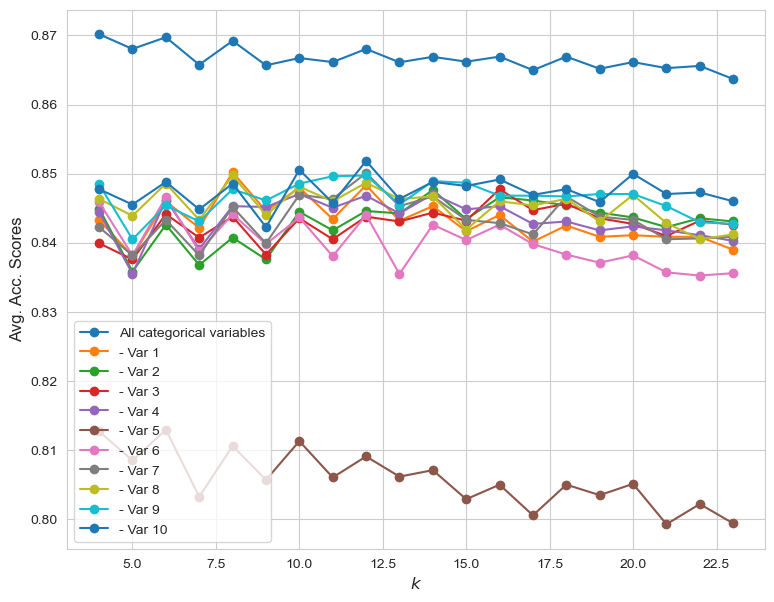

In [47]:
plt.figure(figsize=(9,7))

plt.plot(ks, 
         np.mean(all_accs, axis=0)[:,0],  
         '-o',
         label = 'All categorical variables')

plt.plot(ks, 
         np.mean(all_accs, axis=0)[:,1], 
         '-o',
         label = '- Var 1')

plt.plot(ks, 
         np.mean(all_accs, axis=0)[:,2],
         '-o',
          label = '- Var 2')

plt.plot(ks, 
         np.mean(all_accs, axis=0)[:,3],  
         '-o',
         label = '- Var 3')

plt.plot(ks, 
         np.mean(all_accs, axis=0)[:,4], 
         '-o',
         label = '- Var 4')

plt.plot(ks, 
         np.mean(all_accs, axis=0)[:,5],
         '-o',
          label = '- Var 5')

plt.plot(ks, 
         np.mean(all_accs, axis=0)[:,6],  
         '-o',
         label = '- Var 6')

plt.plot(ks, 
         np.mean(all_accs, axis=0)[:,7], 
         '-o',
         label = '- Var 7')

plt.plot(ks, 
         np.mean(all_accs, axis=0)[:,8],
         '-o',
          label = '- Var 8')

plt.plot(ks, 
         np.mean(all_accs, axis=0)[:,9],  
         '-o',
         label = '- Var 9')

plt.plot(ks, 
         np.mean(all_accs, axis=0)[:,10],  
         '-o',
         label = '- Var 10')





plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.xlabel("$k$", fontsize=12)
plt.ylabel("Avg. Acc. Scores", fontsize=12)
plt.legend()

plt.show()


In [48]:
#It's now clear what variables we need. Let's just do some hyperparameter tuning one last time to finish up.

preprocessor = ColumnTransformer(
    transformers=[
        ("Structure Type", OneHotEncoder(), ['* Structure Type']),
        ("Roof Construction", OneHotEncoder(), ['* Roof Construction']),
        ("Eaves", OneHotEncoder(), ['* Eaves']),
        ("Vent Screen", OneHotEncoder(), ['* Vent Screen']),
        ("Exterior Siding", OneHotEncoder(), ['* Exterior Siding']),
        ("Window Pane", OneHotEncoder(), ['* Window Pane']),
        ("Elevated", OneHotEncoder(), ['* Deck/Porch Elevated']),
        ("Patio Cover/Carport Attached", OneHotEncoder(), ['* Patio Cover/Carport Attached to Structure']),
        ("Fence Attached to Structure", OneHotEncoder(), ['* Fence Attached to Structure']),
        ("Longitude", StandardScaler(), ['Longitude']),
        ("Latitude", StandardScaler(), ['Latitude'])
        ])

#We are ready to start.

n_splits = 50
kfold = StratifiedKFold(n_splits, shuffle=True, random_state=216)
ks = [i for i in range(1,120)]
k_all_accs = np.zeros((n_splits, len(ks)))
k_all_recs = np.zeros((n_splits, len(ks)))
k_all_precs = np.zeros((n_splits, len(ks))) 

i = 0

for train_index, test_index in kfold.split(cal_fire_data_train, cal_fire_data_train['Destroyed']):
    cal_fire_data_tt = cal_fire_data_train.iloc[train_index]
    cal_fire_data_ho = cal_fire_data_train.iloc[test_index]
    j = 0

    for k in ks:
        model = Pipeline([('Preprocess', preprocessor),
                        ('knn',KNeighborsClassifier(k))])

        model.fit(cal_fire_data_tt[['* Structure Type', '* Roof Construction', '* Eaves', '* Vent Screen',
       '* Exterior Siding', '* Window Pane', '* Deck/Porch On Grade',
       '* Deck/Porch Elevated', '* Patio Cover/Carport Attached to Structure',
       '* Fence Attached to Structure', 'Latitude', 'Longitude']],cal_fire_data_tt['Destroyed'])

        pred = model.predict(cal_fire_data_ho[['* Structure Type', '* Roof Construction', '* Eaves', '* Vent Screen',
       '* Exterior Siding', '* Window Pane', '* Deck/Porch On Grade',
       '* Deck/Porch Elevated', '* Patio Cover/Carport Attached to Structure',
       '* Fence Attached to Structure', 'Latitude', 'Longitude']])

        k_all_accs[i,j] = accuracy_score(cal_fire_data_ho.Destroyed.values, pred)
        k_all_precs[i,j] = precision_score(cal_fire_data_ho.Destroyed.values, pred)
        k_all_recs[i,j] = recall_score(cal_fire_data_ho.Destroyed.values, pred)
        j +=1
    i += 1



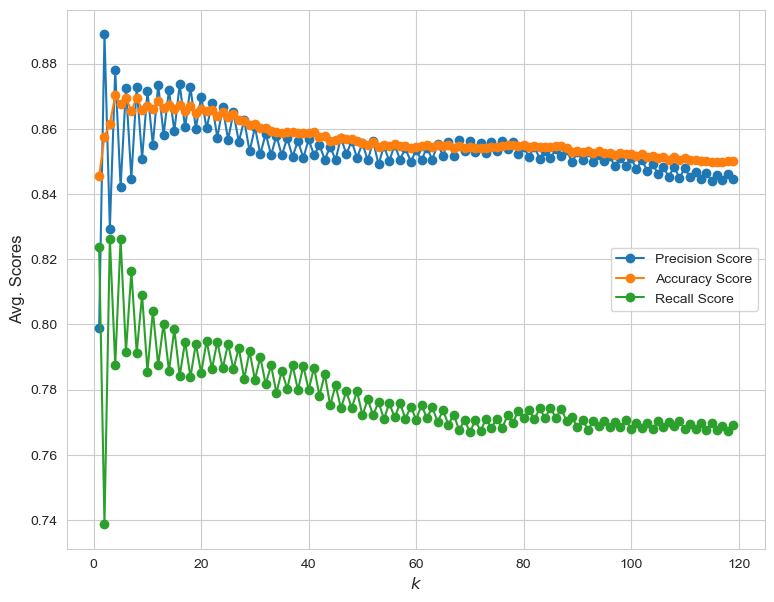

The best accuracy score, 0.8702627310368382 is attained when k= 4 neighbors.
The best precision score, 0.8890022446331105 is attained when k= 2 neighbors.
The best recall score, 0.826331488801054 is attained when k= 3 neighbors.


In [49]:
#Let's visualize this data.

plt.figure(figsize=(9,7))

plt.plot(ks, 
         np.mean(k_all_precs, axis=0),  
         '-o',
         label = 'Precision Score')

plt.plot(ks, 
         np.mean(k_all_accs, axis=0), 
         '-o',
         label = 'Accuracy Score')

plt.plot(ks, 
         np.mean(k_all_recs, axis=0),
         '-o',
          label = 'Recall Score')


plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.xlabel("$k$", fontsize=12)
plt.ylabel("Avg. Scores", fontsize=12)
plt.legend(loc = 'center right')

plt.show()

print('The best accuracy score,', max(np.mean(k_all_accs, axis = 0)), 'is attained when k=', np.argmax(np.mean(k_all_accs, axis = 0)) + 1, 'neighbors.')
print('The best precision score,', max(np.mean(k_all_precs, axis = 0)), 'is attained when k=', np.argmax(np.mean(k_all_precs, axis = 0)) + 1, 'neighbors.')
print('The best recall score,', max(np.mean(k_all_recs, axis = 0)), 'is attained when k=', np.argmax(np.mean(k_all_recs, axis = 0)) + 1, 'neighbors.')


From this, we choose k = 4 neighbors and all the variables but Age and AIV.